<div style="font-family: Arial,sans-serif; color: #3070b3; font-size: 13px; line-height: 14px; ">
    <div style="float:right;">
        <a href="https://www.asg.ed.tum.de/en/lmf" title="Home">
            <img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Logo_of_the_Technical_University_of_Munich.svg" alt="Technical University of Munich" style="height: 42px">
        </a>
    </div>
    <div>
        <ul style="padding: 0pt; margin: 0pt; list-style-type: none;">
            <li> <a href="https://www.asg.ed.tum.de/en/lmf/" title="Home Chair of Remote Sensing Technology" style="text-decoration: none;">Chair of Remote Sensing Technology</a></li>
            <li> <a href="https://www.ed.tum.de/en/" title="Home TUM School of Engineering and Design" style="text-decoration: none;">TUM School of Engineering and Design</a></li>
            <li> <a href="https://www.tum.de/en/" title="Home Technical University of Munich" style="text-decoration: none;"> Technical University of Munich </a></li>
        </ul>
    </div>
</div>

<div style="font-family: Arial,sans-serif; font-size: 14px; line-height: 16px; margin-top:50px">
    <div style="float:right;">
        <span style="font-size:small">Prof. Dr. rer. nat. habil.</span><br />
        <b>Marco Körner</b><br />
    </div>
    <div style="">
        <h1>Machine Learning &mdash; Advanced Methods</h1>
        <p style="font-size:large">Summer Term 2024</p>
    </div>
</div>

---

## 1. Ensemble Learning

In this notebook, we execute a simple ensemble learning strategy.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
import pandas as pd

import cv2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets

## Loading the Dataset

We use the FashionMNIST dataset for our experiment.
If it does not exists already, we try to download it from Kaggle. 
For this, you need to provide a valid Kaggle access key token (cf. https://www.kaggle.com/settings/account).
This is usually stored in a file named `kaggle.json` located in your working directory or in your home directory `~/.kaggle`.
If this file does not exists, this script will ask you for your credentials and create one for you.

In [2]:
import os
if not os.path.exists('./data/fashionmnist'):
    print('Dataset not found!')
    if not (os.path.isfile('kaggle.json') or 
            os.path.isfile('./kaggle.json') or 
            os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json'))
           ):
        username = input('Username:')
        key = input('Key:')
        json = f'{{"username":"{username}","key":"{key}"}}'
        with open("kaggle.json", "w") as f:
            f.write(json)
    else:
        print('kaggle.json found!')
        
    os.system("kaggle datasets download -d zalando-research/fashionmnist")
    os.system("mkdir -p ./data/fashionmnist")
    os.system("unzip fashionmnist.zip -d ./data/fashionmnist")
    os.system("rm fashionmnist.zip")
    
data = pd.read_csv('./data/fashionmnist/fashion-mnist_train.csv', sep = ',')
data.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

## Preparing the Data

The FashionMNIST dataset doesn't come with descriptive labels, so we provide our owns.

For further numerical stability, we normalize the intensity values to $[0,1] \subset \mathbb{R}$.
A small dataset browser helps us checking if everything went fine.

In [3]:
X,y = data.drop(['label'], axis = 1), data['label']

label_dictionnary = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 
                     3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 
                     7:'Sneaker', 8:'Bag', 9:'Ankle boot' }

In [4]:
X /= 255.

In [5]:
@interact(example = (1,len(X)))
def doBrowse(example = 16):
    g = plt.imshow(X.values.reshape(-1,28,28,1)[example][:,:,0], cmap='gray')
    print('this represent a : ' + label_dictionnary[y[example]])

interactive(children=(IntSlider(value=16, description='example', max=60000, min=1), Output()), _dom_classes=('…

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Although the FashinMNIST images are rather small ($\boldsymbol{x} \in \mathbb{R}^{28 \times 28}$), their pixels show a considerable amount of redundancy.
Hence, we perform a simple dimensionality reduction by keeping only the first two principal components, these already explain ca. $47\%$ of the dataset variance.

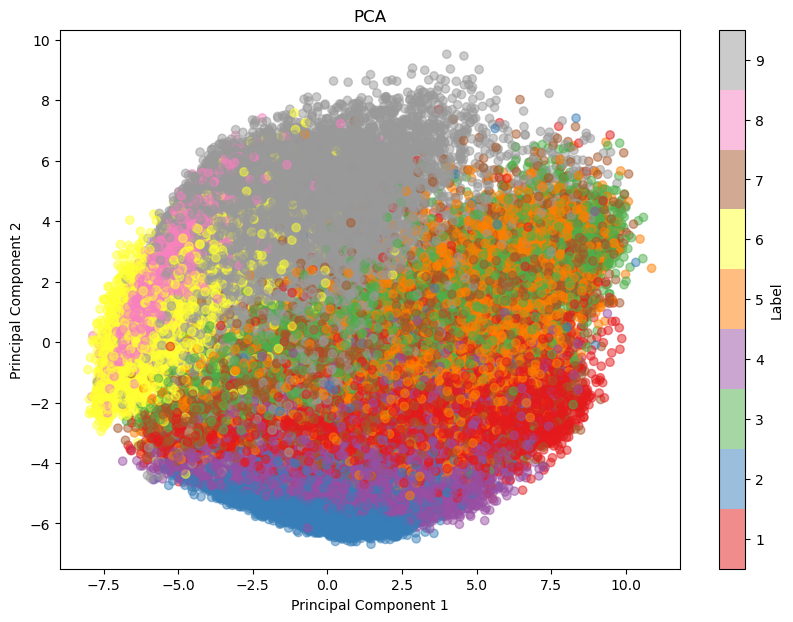

Explained variance ratio: [0.2898411  0.17740469] (Σ=46.72%)


In [7]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

# Visualization of the PCA results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train+.5, cmap='Set1', alpha=0.5)
plt.colorbar(scatter, label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_} (Σ={100*np.sum(pca.explained_variance_ratio_):.2f}%)")

## Preparing Base Classifiers

We will train a variety of classifiers and evaluate them on the held-out test sub-dataset, their performances are reported per classifier instance.
Feel free to add further classification models.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

classifiers = {
    '1nn': KNeighborsClassifier(n_neighbors=1),
    '3nn': KNeighborsClassifier(n_neighbors=3),
    '5nn': KNeighborsClassifier(n_neighbors=3),
    'DT': tree.DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'SVM (linear)': LinearSVC(dual='auto'),
    # 'SVM (linear)': SVC(kernel='linear'), # !!! slower training !!!
    # 'SVM (poly)': SVC(kernel='poly'), #!!! slow training !!!
    # 'SVM (rbf)': SVC(kernel='rbf'),  #!!! slow training !!!
}

X_test_reduced = pca.transform(X_test)
ohe = np.eye(len(label_dictionnary))

y_ = dict()
y_c = np.zeros_like(ohe[y_test])
acc_ = dict()

for clf_name, clf in classifiers.items():
    clf.fit(X_train_reduced, y_train)
    y__ = clf.predict(X_test_reduced)
    y_c += ohe[y__]
    y_[clf_name] = y__

    acc = np.sum(y_[clf_name] == y_test)/len(y_test)
    acc_[clf_name] = acc
    print(f'{clf_name: >15}: {100*acc:.2f}%')

            1nn: 46.26%
            3nn: 49.71%
            5nn: 49.71%
             DT: 45.16%
             NB: 49.96%
   SVM (linear): 44.01%


## Building a Committee

As you can see, all classifiers show different performances on the test dataset. 
Our assumption is that these classifiers are _diverse_, _i.e._, the errors they make are uncorrelated.
Then, we can build an _ensemble_, or a _committee_, of classifiers.

In particular, we want to follow a _max-voting scheme_.
To do so, we convert each predicted label into a _one-hot-vector_ representation, _i.e._,$y = 5 \mapsto \boldsymbol{y} = (0,0,0,0,1,0,0,0,0,0)$, and sum them up. 
The class with the majority of class votes will be our final prediction.

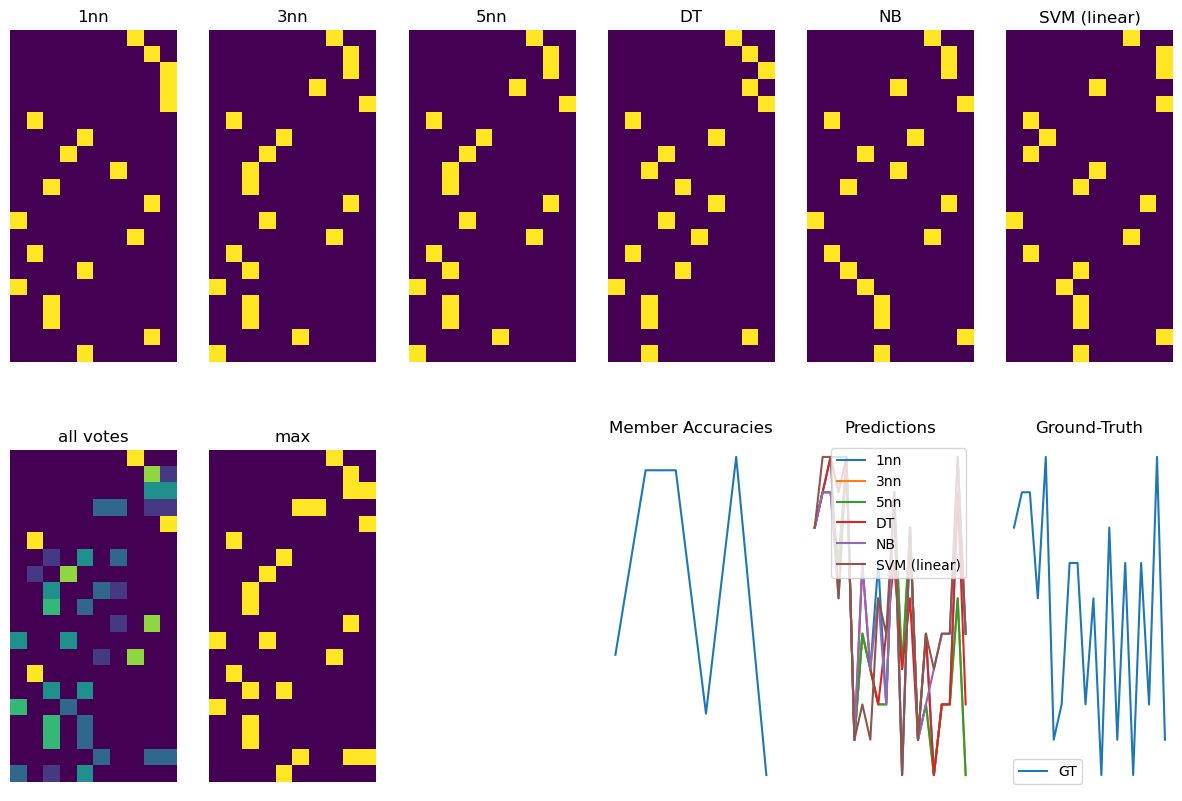

In [9]:
_, axs = plt.subplots(2,max(5,len(classifiers)), figsize=(15,10))
for (name, y__), ax in zip(y_.items(), axs[0,:]):
    ax.imshow(ohe[y__][:20])
    ax.set_title(name)
    
    axs[1,-2].plot(y__[:20], label=name)

axs[1,0].imshow(y_c[:20])
axs[1,0].set_title('all votes')
axs[1,1].imshow((y_c == np.tile(np.max(y_c, axis=1), (10,1)).T)[:20])
axs[1,1].set_title('max')

axs[1,-1].plot(y_test.values[:20], label='GT') 
axs[1,-1].set_title('Ground-Truth')
axs[1,-3].plot(acc_.keys(), acc_.values())
axs[1,-3].set_title('Member Accuracies')
axs[1,-1].legend()
axs[1,-2].legend()
axs[1,-2].set_title('Predictions')

[ax.axis('off') for ax in axs.ravel()];

In [10]:
print(f'ensemble accuracy: {100*np.sum(np.argmax(y_c, axis=1) == y_test.values)/len(y_test):.2f}%')

ensemble accuracy: 50.25%


Apparently, the ensemble classifier outperforms each individual base classifier.
That's great!